In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "batch"
cell_type_key = 'celltype'
target_conditions = ["Batch8", "Batch9"]

# Loading four Toy datasets and data preparation

In [4]:
adata = sc.read("./data/toy/toy_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 36000 × 5000 
    obs: 'batch', 'celltype', 'n_counts'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Batch9    4000
Batch8    4000
Batch7    4000
Batch6    4000
Batch5    4000
Batch4    4000
Batch3    4000
Batch2    4000
Batch1    4000
Name: batch, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [6]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 28000 × 5000 
    obs: 'batch', 'celltype', 'n_counts'

In [7]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 8000 × 5000 
    obs: 'batch', 'celltype', 'n_counts'

## Train/Test Split

In [8]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [9]:
train_adata.shape, valid_adata.shape

((23800, 5000), (4200, 5000))

In [10]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [11]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=1e6,
                             loss_fn='mse',
                             model_path="./models/CVAE/Toy_normalized/",
                             dropout_rate=0.2,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 5000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 7)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 5007)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [12]:
conditions = adata_for_training.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

## Training the network

In [13]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=200,
              batch_size=128, 
              early_stop_limit=20,
              lr_reducer=15, 
              n_per_epoch=0,
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 23800 samples, validate on 4200 samples
Epoch 1/200
 - 3s - loss: 1261.1686 - kl_recon_loss: 1261.1686 - val_loss: 1015.2761 - val_kl_recon_loss: 1015.2761
Epoch 2/200
 - 2s - loss: 823.3000 - kl_recon_loss: 823.3000 - val_loss: 809.0879 - val_kl_recon_loss: 809.0879
Epoch 3/200
 - 2s - loss: 801.0442 - kl_recon_loss: 801.0442 - val_loss: 770.6846 - val_kl_recon_loss: 770.6846
Epoch 4/200
 - 2s - loss: 790.0905 - kl_recon_loss: 790.0905 - val_loss: 765.2393 - val_kl_recon_loss: 765.2393
Epoch 5/200
 - 2s - loss: 783.4413 - kl_recon_loss: 783.4413 - val_loss: 755.8038 - val_kl_recon_loss: 755.8038
Epoch 6/200
 - 3s - loss: 777.5803 - kl_recon_loss: 777.5803 - val_loss: 760.8722 - val_kl_recon_loss: 760.8722
Epoch 7/200
 - 2s - loss: 773.2007 - kl_recon_loss: 773.2007 - val_loss: 757.7767 - val_kl_recon_loss: 757.7767
Epoch 8/200
 - 2s - loss: 770.0187 - kl_recon_loss: 770.0187 - val_loss: 749.8304 - val_kl_recon_loss: 749.8304
Epo

In [14]:
network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

In [15]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [16]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 23800 × 20 
    obs: 'batch', 'celltype', 'n_counts'

In [17]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


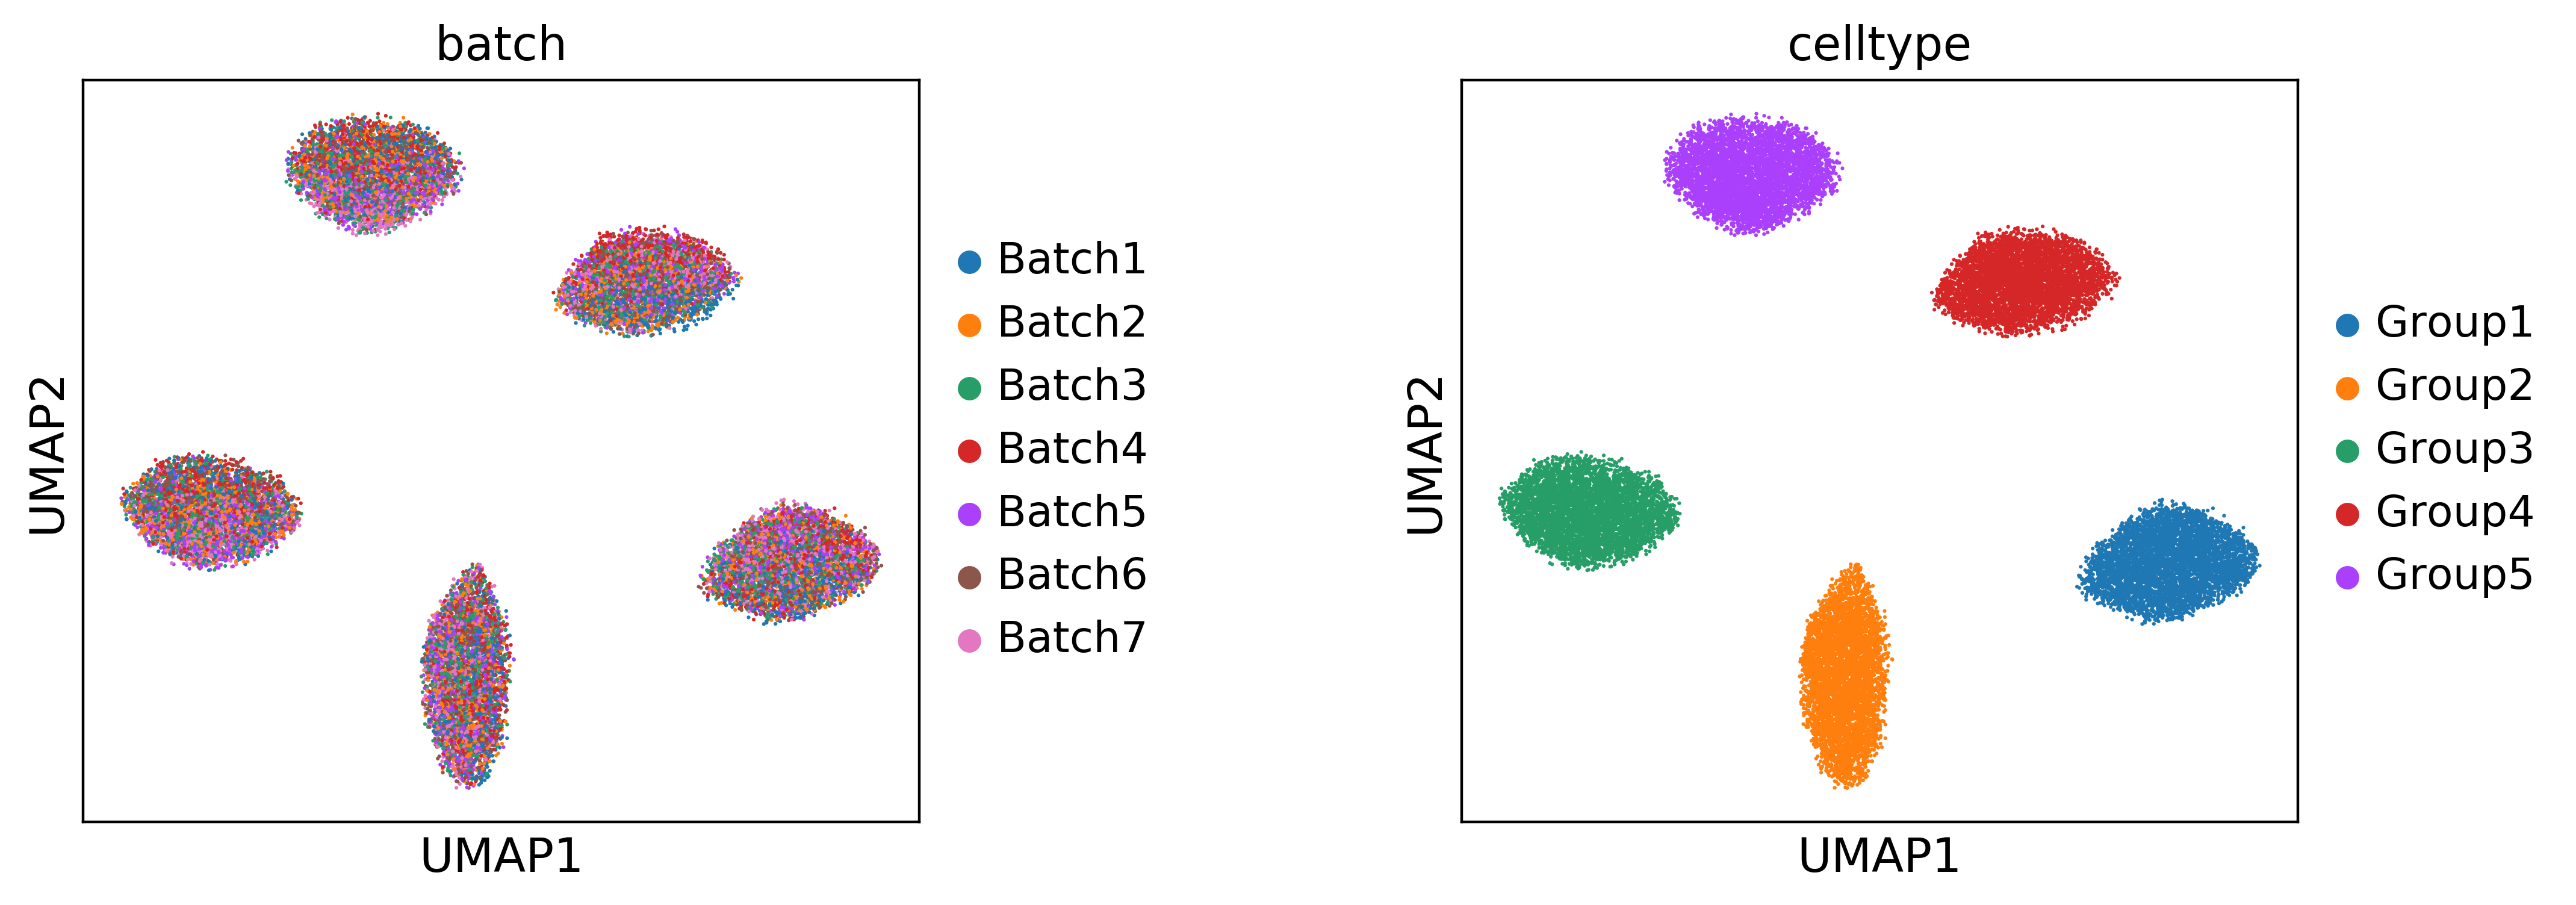

In [18]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [17]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 5000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 9)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 5009)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          2564608     concatenate_3[0][0]              
__________

In [18]:
new_network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6,
 'Batch8': 7,
 'Batch9': 8}

## Train with small new dataset containing out-of-sample condition

In [19]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [20]:
train_adata.shape, valid_adata.shape

((6800, 5000), (1200, 5000))

In [21]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  n_per_epoch=5,
                  score_filename="./results/convergence/toy/scores_scNetUnFreezed_count.log",
                  save=True, 
                  verbose=2)

Train on 6800 samples, validate on 1200 samples
Epoch 1/100
 - 2s - loss: 747.2766 - kl_recon_loss: 747.2766 - val_loss: 739.5744 - val_kl_recon_loss: 739.5744
Epoch 0: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0384 - ARI: 0.0352 - NMI: 0.0751 - EBM: 0.6820
Epoch 2/100
 - 0s - loss: 737.8145 - kl_recon_loss: 737.8145 - val_loss: 737.1220 - val_kl_recon_loss: 737.1220
Epoch 3/100
 - 1s - loss: 730.8271 - kl_recon_loss: 730.8271 - val_loss: 735.2629 - val_kl_recon_loss: 735.2629
Epoch 4/100
 - 1s - loss: 729.4441 - kl_recon_loss: 729.4441 - val_loss: 730.4657 - val_kl_recon_loss: 730.4657
Epoch 5/100
 - 1s - loss: 728.9637 - kl_recon_loss: 728.9637 - val_loss: 728.9960 - val_kl_recon_loss: 728.9960
Epoch 6/100
 - 1s - loss: 728.7231 - kl_recon_loss: 728.7231 - val_loss: 728.8156 - val_kl_recon_loss: 728.8156
Epoch 5: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1835 - ARI: 0.1632 - NMI: 0.4562 - EBM: 0.6835
Epoch 7/100
 - 0s - loss: 728.5582 - kl_recon_loss: 728.5582 - val_loss: 728.6062 - val_kl_recon_loss: 728.6062
Epoch 8/100
 - 0s - loss: 728.1237 - kl_recon_loss: 728.1237 - val_loss: 728.2398 - val_kl_recon_loss: 728.2398
Epoch 9/100
 - 1s - loss: 728.0232 - kl_recon_loss: 728.0232 - val_loss: 728.1531 - val_kl_recon_loss: 728.1531
Epoch 10/100
 - 1s - loss: 727.7792 - kl_recon_loss: 727.7792 - val_loss: 728.1849 - val_kl_recon_loss: 728.1849
Epoch 11/100
 - 1s - loss: 727.5740 - kl_recon_loss: 727.5740 - val_loss: 728.1296 - val_kl_recon_loss: 728.1296
Epoch 10: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1186 - ARI: 0.1629 - NMI: 0.4542 - EBM: 0.6823
Epoch 12/100
 - 0s - loss: 727.4576 - kl_recon_loss: 727.4576 - val_loss: 728.0616 - val_kl_recon_loss: 728.0616
Epoch 13/100
 - 0s - loss: 727.4086 - kl_recon_loss: 727.4086 - val_loss: 728.1150 - val_kl_recon_loss: 728.1150
Epoch 14/100
 - 1s - loss: 727.2258 - kl_recon_loss: 727.2258 - val_loss: 728.1685 - val_kl_recon_loss: 728.1685
Epoch 15/100
 - 1s - loss: 727.2499 - kl_recon_loss: 727.2499 - val_loss: 728.8689 - val_kl_recon_loss: 728.8689
Epoch 16/100
 - 1s - loss: 726.9939 - kl_recon_loss: 726.9939 - val_loss: 728.1227 - val_kl_recon_loss: 728.1227
Epoch 15: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.1006 - ARI: 0.1608 - NMI: 0.4423 - EBM: 0.6837
Epoch 17/100
 - 1s - loss: 726.7343 - kl_recon_loss: 726.7343 - val_loss: 728.5161 - val_kl_recon_loss: 728.5161
Epoch 18/100
 - 1s - loss: 726.6895 - kl_recon_loss: 726.6895 - val_loss: 728.6188 - val_kl_recon_loss: 728.6188
Epoch 19/100
 - 1s - loss: 726.5785 - kl_recon_loss: 726.5785 - val_loss: 728.1527 - val_kl_recon_loss: 728.1527
Epoch 20/100
 - 1s - loss: 726.4248 - kl_recon_loss: 726.4248 - val_loss: 728.1878 - val_kl_recon_loss: 728.1878
Epoch 21/100
 - 1s - loss: 726.3749 - kl_recon_loss: 726.3749 - val_loss: 728.5844 - val_kl_recon_loss: 728.5844
Epoch 20: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0851 - ARI: 0.1498 - NMI: 0.3981 - EBM: 0.6835
Epoch 22/100
 - 0s - loss: 726.2532 - kl_recon_loss: 726.2532 - val_loss: 728.2381 - val_kl_recon_loss: 728.2381
Epoch 23/100
 - 0s - loss: 726.0933 - kl_recon_loss: 726.0933 - val_loss: 728.3583 - val_kl_recon_loss: 728.3583
Epoch 24/100
 - 0s - loss: 726.0066 - kl_recon_loss: 726.0066 - val_loss: 728.3088 - val_kl_recon_loss: 728.3088
Epoch 25/100
 - 0s - loss: 725.8500 - kl_recon_loss: 725.8500 - val_loss: 729.2016 - val_kl_recon_loss: 729.2016
Epoch 26/100
 - 0s - loss: 725.7720 - kl_recon_loss: 725.7720 - val_loss: 728.3643 - val_kl_recon_loss: 728.3643
Epoch 25: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0696 - ARI: 0.0362 - NMI: 0.0800 - EBM: 0.6837
Epoch 27/100
 - 0s - loss: 725.6715 - kl_recon_loss: 725.6715 - val_loss: 728.4750 - val_kl_recon_loss: 728.4750
Epoch 28/100
 - 1s - loss: 725.5646 - kl_recon_loss: 725.5646 - val_loss: 728.1957 - val_kl_recon_loss: 728.1957
Epoch 29/100
 - 0s - loss: 725.4831 - kl_recon_loss: 725.4831 - val_loss: 728.4062 - val_kl_recon_loss: 728.4062
Epoch 30/100
 - 1s - loss: 725.4343 - kl_recon_loss: 725.4343 - val_loss: 728.2020 - val_kl_recon_loss: 728.2020
Epoch 31/100
 - 1s - loss: 725.3025 - kl_recon_loss: 725.3025 - val_loss: 728.4372 - val_kl_recon_loss: 728.4372
Epoch 30: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0591 - ARI: 0.0229 - NMI: 0.0484 - EBM: 0.6832
Epoch 32/100
 - 0s - loss: 725.1850 - kl_recon_loss: 725.1850 - val_loss: 728.2619 - val_kl_recon_loss: 728.2619
Epoch 33/100
 - 0s - loss: 724.4479 - kl_recon_loss: 724.4479 - val_loss: 727.8946 - val_kl_recon_loss: 727.8946
Epoch 34/100
 - 0s - loss: 724.2240 - kl_recon_loss: 724.2240 - val_loss: 727.8131 - val_kl_recon_loss: 727.8131
Epoch 35/100
 - 1s - loss: 724.2245 - kl_recon_loss: 724.2245 - val_loss: 727.8109 - val_kl_recon_loss: 727.8109
Epoch 36/100
 - 1s - loss: 724.2047 - kl_recon_loss: 724.2047 - val_loss: 727.8514 - val_kl_recon_loss: 727.8514
Epoch 35: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0541 - ARI: 0.0152 - NMI: 0.0296 - EBM: 0.6839
Epoch 37/100
 - 0s - loss: 724.1156 - kl_recon_loss: 724.1156 - val_loss: 727.8141 - val_kl_recon_loss: 727.8141
Epoch 38/100
 - 0s - loss: 724.1303 - kl_recon_loss: 724.1303 - val_loss: 727.8004 - val_kl_recon_loss: 727.8004
Epoch 39/100
 - 1s - loss: 724.0499 - kl_recon_loss: 724.0499 - val_loss: 727.8004 - val_kl_recon_loss: 727.8004
Epoch 40/100
 - 1s - loss: 724.1809 - kl_recon_loss: 724.1809 - val_loss: 727.7924 - val_kl_recon_loss: 727.7924
Epoch 41/100
 - 1s - loss: 724.1705 - kl_recon_loss: 724.1705 - val_loss: 727.7881 - val_kl_recon_loss: 727.7881
Epoch 40: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0544 - ARI: 0.0152 - NMI: 0.0313 - EBM: 0.6826
Epoch 42/100
 - 0s - loss: 724.0403 - kl_recon_loss: 724.0403 - val_loss: 727.8073 - val_kl_recon_loss: 727.8073
Epoch 43/100
 - 0s - loss: 723.9985 - kl_recon_loss: 723.9985 - val_loss: 727.7952 - val_kl_recon_loss: 727.7952
Epoch 44/100
 - 1s - loss: 724.0674 - kl_recon_loss: 724.0674 - val_loss: 727.7967 - val_kl_recon_loss: 727.7967
Epoch 45/100
 - 1s - loss: 724.0285 - kl_recon_loss: 724.0285 - val_loss: 727.8083 - val_kl_recon_loss: 727.8083
Epoch 46/100
 - 1s - loss: 724.0762 - kl_recon_loss: 724.0762 - val_loss: 727.7928 - val_kl_recon_loss: 727.7928
Epoch 45: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0530 - ARI: 0.0152 - NMI: 0.0301 - EBM: 0.6824
Epoch 47/100
 - 0s - loss: 723.9474 - kl_recon_loss: 723.9474 - val_loss: 727.7879 - val_kl_recon_loss: 727.7879
Epoch 48/100
 - 0s - loss: 724.0291 - kl_recon_loss: 724.0291 - val_loss: 727.8197 - val_kl_recon_loss: 727.8197
Epoch 49/100
 - 1s - loss: 723.9537 - kl_recon_loss: 723.9537 - val_loss: 727.7891 - val_kl_recon_loss: 727.7891
Epoch 50/100
 - 1s - loss: 724.1074 - kl_recon_loss: 724.1074 - val_loss: 727.8232 - val_kl_recon_loss: 727.8232
Epoch 51/100
 - 1s - loss: 723.9792 - kl_recon_loss: 723.9792 - val_loss: 727.7930 - val_kl_recon_loss: 727.7930
Epoch 50: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0510 - ARI: 0.0133 - NMI: 0.0279 - EBM: 0.6821
Epoch 52/100
 - 0s - loss: 723.9686 - kl_recon_loss: 723.9686 - val_loss: 727.8118 - val_kl_recon_loss: 727.8118
Epoch 53/100
 - 0s - loss: 723.9798 - kl_recon_loss: 723.9798 - val_loss: 727.7979 - val_kl_recon_loss: 727.7979
Epoch 54/100
 - 0s - loss: 723.9305 - kl_recon_loss: 723.9305 - val_loss: 727.7929 - val_kl_recon_loss: 727.7929
Epoch 55/100
 - 1s - loss: 723.8589 - kl_recon_loss: 723.8589 - val_loss: 727.7924 - val_kl_recon_loss: 727.7924
Epoch 56/100
 - 1s - loss: 724.0060 - kl_recon_loss: 724.0060 - val_loss: 727.8188 - val_kl_recon_loss: 727.8188
Epoch 55: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0501 - ARI: 0.0143 - NMI: 0.0297 - EBM: 0.6834
Epoch 57/100
 - 0s - loss: 723.8854 - kl_recon_loss: 723.8854 - val_loss: 727.8139 - val_kl_recon_loss: 727.8139
Epoch 58/100
 - 1s - loss: 723.8488 - kl_recon_loss: 723.8488 - val_loss: 727.8562 - val_kl_recon_loss: 727.8562
Epoch 59/100
 - 1s - loss: 723.9112 - kl_recon_loss: 723.9112 - val_loss: 727.8172 - val_kl_recon_loss: 727.8172
Epoch 60/100
 - 1s - loss: 723.8632 - kl_recon_loss: 723.8632 - val_loss: 727.7968 - val_kl_recon_loss: 727.7968
Epoch 61/100
 - 1s - loss: 723.8477 - kl_recon_loss: 723.8477 - val_loss: 727.8074 - val_kl_recon_loss: 727.8074
Epoch 60: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0484 - ARI: 0.0126 - NMI: 0.0261 - EBM: 0.6822
Epoch 62/100
 - 0s - loss: 723.9254 - kl_recon_loss: 723.9254 - val_loss: 727.8044 - val_kl_recon_loss: 727.8044
Epoch 63/100
 - 1s - loss: 723.8245 - kl_recon_loss: 723.8245 - val_loss: 727.8235 - val_kl_recon_loss: 727.8235
Epoch 64/100
 - 1s - loss: 723.8511 - kl_recon_loss: 723.8511 - val_loss: 727.8046 - val_kl_recon_loss: 727.8046
Epoch 65/100
 - 1s - loss: 723.8193 - kl_recon_loss: 723.8193 - val_loss: 727.8509 - val_kl_recon_loss: 727.8509
Epoch 66/100
 - 1s - loss: 723.8298 - kl_recon_loss: 723.8298 - val_loss: 727.8211 - val_kl_recon_loss: 727.8211
Epoch 65: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0473 - ARI: 0.0127 - NMI: 0.0261 - EBM: 0.6835
Epoch 67/100
 - 0s - loss: 723.8138 - kl_recon_loss: 723.8138 - val_loss: 727.8306 - val_kl_recon_loss: 727.8306
Epoch 68/100
 - 1s - loss: 723.6921 - kl_recon_loss: 723.6921 - val_loss: 727.7754 - val_kl_recon_loss: 727.7754
Epoch 69/100
 - 0s - loss: 723.6588 - kl_recon_loss: 723.6588 - val_loss: 727.7861 - val_kl_recon_loss: 727.7861
Epoch 70/100
 - 0s - loss: 723.6923 - kl_recon_loss: 723.6923 - val_loss: 727.7733 - val_kl_recon_loss: 727.7733
Epoch 71/100
 - 1s - loss: 723.6754 - kl_recon_loss: 723.6754 - val_loss: 727.7857 - val_kl_recon_loss: 727.7857
Epoch 70: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0473 - ARI: 0.0126 - NMI: 0.0265 - EBM: 0.6840
Epoch 72/100
 - 0s - loss: 723.7904 - kl_recon_loss: 723.7904 - val_loss: 727.7783 - val_kl_recon_loss: 727.7783
Epoch 73/100
 - 1s - loss: 723.6979 - kl_recon_loss: 723.6979 - val_loss: 727.7751 - val_kl_recon_loss: 727.7751
Epoch 74/100
 - 1s - loss: 723.7430 - kl_recon_loss: 723.7430 - val_loss: 727.7760 - val_kl_recon_loss: 727.7760
Epoch 75/100
 - 1s - loss: 723.6823 - kl_recon_loss: 723.6823 - val_loss: 727.7782 - val_kl_recon_loss: 727.7782
Epoch 76/100
 - 1s - loss: 723.7320 - kl_recon_loss: 723.7320 - val_loss: 727.7727 - val_kl_recon_loss: 727.7727
Epoch 75: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0470 - ARI: 0.0125 - NMI: 0.0260 - EBM: 0.6831
Epoch 77/100
 - 0s - loss: 723.6564 - kl_recon_loss: 723.6564 - val_loss: 727.7741 - val_kl_recon_loss: 727.7741
Epoch 78/100
 - 1s - loss: 723.7763 - kl_recon_loss: 723.7763 - val_loss: 727.7692 - val_kl_recon_loss: 727.7692
Epoch 79/100
 - 1s - loss: 723.7082 - kl_recon_loss: 723.7082 - val_loss: 727.7716 - val_kl_recon_loss: 727.7716
Epoch 80/100
 - 1s - loss: 723.6706 - kl_recon_loss: 723.6706 - val_loss: 727.7752 - val_kl_recon_loss: 727.7752
Epoch 81/100
 - 1s - loss: 723.7419 - kl_recon_loss: 723.7419 - val_loss: 727.7719 - val_kl_recon_loss: 727.7719
Epoch 80: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0471 - ARI: 0.0127 - NMI: 0.0263 - EBM: 0.6827
Epoch 82/100
 - 0s - loss: 723.7686 - kl_recon_loss: 723.7686 - val_loss: 727.7763 - val_kl_recon_loss: 727.7763
Epoch 83/100
 - 0s - loss: 723.6623 - kl_recon_loss: 723.6623 - val_loss: 727.7765 - val_kl_recon_loss: 727.7765
Epoch 84/100
 - 0s - loss: 723.6704 - kl_recon_loss: 723.6704 - val_loss: 727.7761 - val_kl_recon_loss: 727.7761
Epoch 85/100
 - 0s - loss: 723.6452 - kl_recon_loss: 723.6452 - val_loss: 727.7711 - val_kl_recon_loss: 727.7711
Epoch 86/100
 - 1s - loss: 723.6775 - kl_recon_loss: 723.6775 - val_loss: 727.7747 - val_kl_recon_loss: 727.7747
Epoch 85: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0471 - ARI: 0.0125 - NMI: 0.0260 - EBM: 0.6817
Epoch 87/100
 - 0s - loss: 723.7165 - kl_recon_loss: 723.7165 - val_loss: 727.7793 - val_kl_recon_loss: 727.7793
Epoch 88/100
 - 1s - loss: 723.6567 - kl_recon_loss: 723.6567 - val_loss: 727.7788 - val_kl_recon_loss: 727.7788
Epoch 89/100
 - 1s - loss: 723.7032 - kl_recon_loss: 723.7032 - val_loss: 727.7799 - val_kl_recon_loss: 727.7799
Epoch 90/100
 - 1s - loss: 723.6531 - kl_recon_loss: 723.6531 - val_loss: 727.7812 - val_kl_recon_loss: 727.7812
Epoch 91/100
 - 1s - loss: 723.7228 - kl_recon_loss: 723.7228 - val_loss: 727.7787 - val_kl_recon_loss: 727.7787
Epoch 90: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0470 - ARI: 0.0128 - NMI: 0.0263 - EBM: 0.6838
Epoch 92/100
 - 0s - loss: 723.7492 - kl_recon_loss: 723.7492 - val_loss: 727.7848 - val_kl_recon_loss: 727.7848
Epoch 93/100
 - 1s - loss: 723.7688 - kl_recon_loss: 723.7688 - val_loss: 727.7770 - val_kl_recon_loss: 727.7770
Epoch 94/100
 - 1s - loss: 723.6290 - kl_recon_loss: 723.6290 - val_loss: 727.7778 - val_kl_recon_loss: 727.7778
Epoch 95/100
 - 1s - loss: 723.6108 - kl_recon_loss: 723.6108 - val_loss: 727.7888 - val_kl_recon_loss: 727.7888
Epoch 96/100
 - 1s - loss: 723.7052 - kl_recon_loss: 723.7052 - val_loss: 727.7719 - val_kl_recon_loss: 727.7719
Epoch 95: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0468 - ARI: 0.0126 - NMI: 0.0258 - EBM: 0.6841
Epoch 97/100
 - 0s - loss: 723.6395 - kl_recon_loss: 723.6395 - val_loss: 727.7843 - val_kl_recon_loss: 727.7843
Epoch 98/100
 - 0s - loss: 723.6470 - kl_recon_loss: 723.6470 - val_loss: 727.7737 - val_kl_recon_loss: 727.7737
Epoch 99/100
 - 1s - loss: 723.7881 - kl_recon_loss: 723.7881 - val_loss: 727.7727 - val_kl_recon_loss: 727.7727
Epoch 100/100
 - 1s - loss: 723.6753 - kl_recon_loss: 723.6753 - val_loss: 727.7747 - val_kl_recon_loss: 727.7747


In [22]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [23]:
adata_out_of_sample.obs[condition_key].value_counts()

Batch9    4000
Batch8    4000
Name: batch, dtype: int64

In [24]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8000 × 20 
    obs: 'batch', 'celltype', 'n_counts'

In [25]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

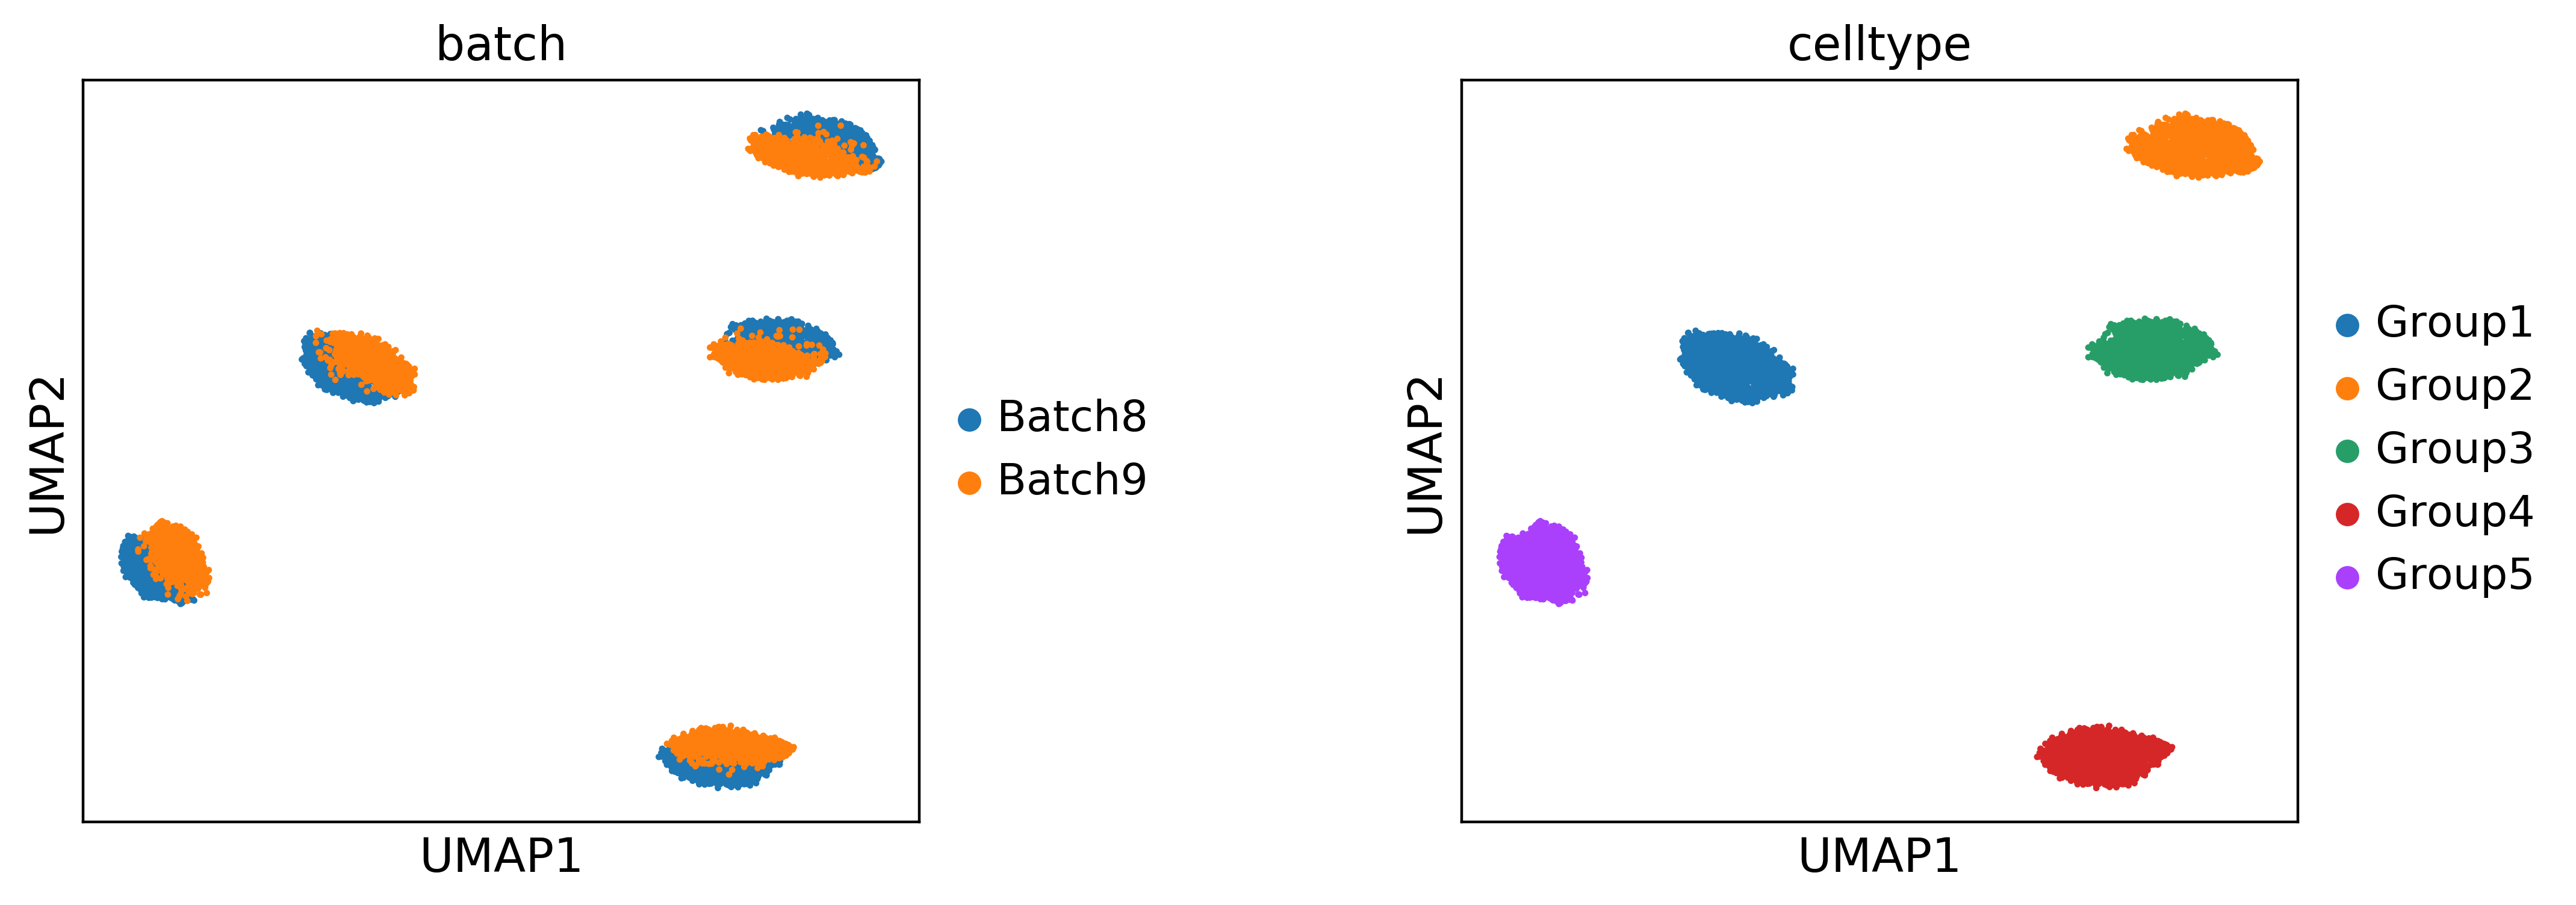

In [26]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [29]:
surgeon.metrics.entropy_batch_mixing(latent_adata, label_key=condition_key, n_pools=1)

0.6000959187730008

In [30]:
surgeon.metrics.asw(latent_adata, condition_key)

0.018442642

In [31]:
surgeon.metrics.ari(latent_adata, condition_key)

0.00016825364791735295

In [32]:
surgeon.metrics.nmi(latent_adata, condition_key)

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.00033019275891427207